In [1]:
from graphviz import Digraph
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib widget
%pip install graphviz


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (
            n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op,)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


Note: you may need to restart the kernel to use updated packages.


In [2]:
class Value:
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):  # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __rtruediv__(self, other):  # other / self
        return other * self**-1

    def __pow__(self, other):  # self**other
        assert isinstance(other, (int, float)
                          ), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            # d/dx(x^n) = n*x^(n-1)
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad  # exp(x) derived is exp(x)
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


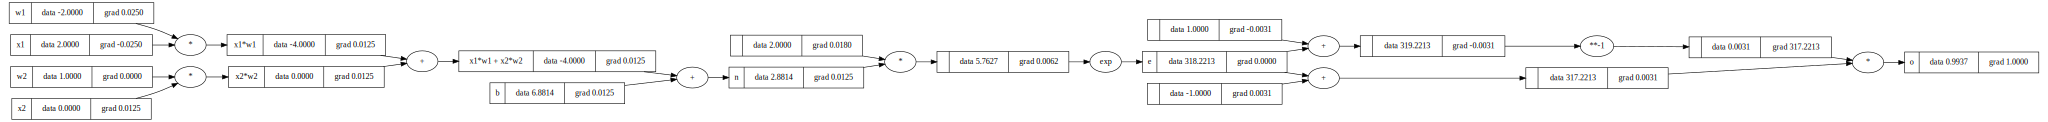

In [3]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-2.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp()
e.label = 'e'
o = (e-1) / (e+1)  # tanh(n)
o.label = 'o'

o.backward()
draw_dot(o)


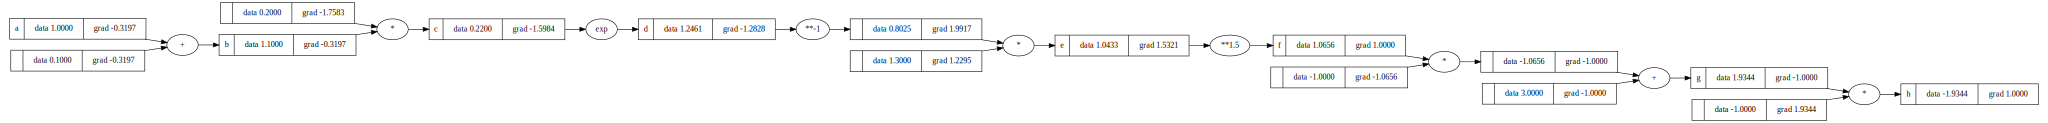

In [4]:
a = Value(1.0, label='a')
b = 0.1 + a  # radd
b.label = 'b'
c = 0.2 * b  # rmul
c.label = 'c'
d = c.exp()
d.label = 'd'
e = 1.3 / d  # rtruediv
e.label = 'e'
f = e**1.5  # pow
f.label = 'f'
g = 3 - f  # rsub
g.label = 'g'
h = -g  # neg
h.label = 'h'

h.backward()
draw_dot(h)


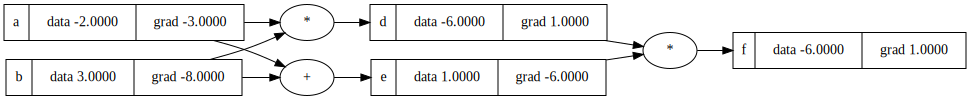

In [5]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'
f.backward()
draw_dot(f)


In [6]:
import random


class Neuron:
    def __init__(self, nin, label=""):
        self.label = label
        self.w = [Value(random.uniform(-1, 1),
                        label=f"{label} w{i}") for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label=f"{label} b")

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        out.label = f"{self.label} O"
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout, label=""):
        self.neurons = [Neuron(nin, label=f"{label}N{i}") for i in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [
            Layer(sz[i], sz[i+1], label=f"L{i}") for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


n = MLP(3, [4, 4, 1])

# x = [Value(2.0, label="x1"), Value(3.0, label="x2"), Value(-1.0, label="x3")]
# out = n(x)
# out.backward()
# draw_dot(out)


In [7]:

n = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets


In [8]:
learning_rate = -0.48
k = 0
loss = Value(1)
while loss.data > 0.000001:
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # zero_grad
    loss.backward()

    # update
    for p in n.parameters():
        p.data += learning_rate * p.grad

    if (k % 1000 == 0):
        print(k, loss.data) 
    k+=1
print(k, loss.data, ypred)

0 6.433187838679187
1000 1.2781402708140665e-05
2000 7.587448842847985e-06
3000 5.448409695372291e-06
4000 4.260428674506796e-06
5000 3.500011790620228e-06
6000 2.970099882911728e-06
7000 2.579126431022654e-06
8000 2.2785424543406503e-06
9000 2.0401380230460546e-06
10000 1.8463729827466033e-06
11000 1.6857559811260265e-06
12000 1.5504381354679651e-06
13000 1.4348728069009812e-06
14000 1.3350275441338322e-06
15000 1.2478994882900037e-06
16000 1.1712059574094538e-06
17000 1.103180439363808e-06
18000 1.042434302396167e-06
18770 9.99968728058494e-07 [Value(data=0.9999981840334069), Value(data=-0.999133034905575), Value(data=-0.9995016692015859), Value(data=0.9999981640467055)]


In [9]:
print("TODO: animate loss plot with mathplotlib")

TODO: animate loss plot with mathplotlib
